In [1]:
library(dplyr)
library(splines)
library(ggplot2)

# Best paper so far:

# https://www.researchgate.net/profile/Robin_Candau/publication/15242395_Fatigue_and_fitness_modelled_from_the_effects_of_training_on_performance/links/55720f2608ae7536374cdc09/Fatigue-and-fitness-modelled-from-the-effects-of-training-on-performance.pdf

# Article describing the Cp
# https://www.researchgate.net/publication/20910238_Modeling_human_performance_in_running



Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




[Best paper so far](https://www.researchgate.net/profile/Robin_Candau/publication/15242395_Fatigue_and_fitness_modelled_from_the_effects_of_training_on_performance/links/55720f2608ae7536374cdc09/Fatigue-and-fitness-modelled-from-the-effects-of-training-on-performance.pdf)

[Article describing the Cp](https://www.researchgate.net/publication/20910238_Modeling_human_performance_in_running)


[1] 34.06803

[1] 24.03571

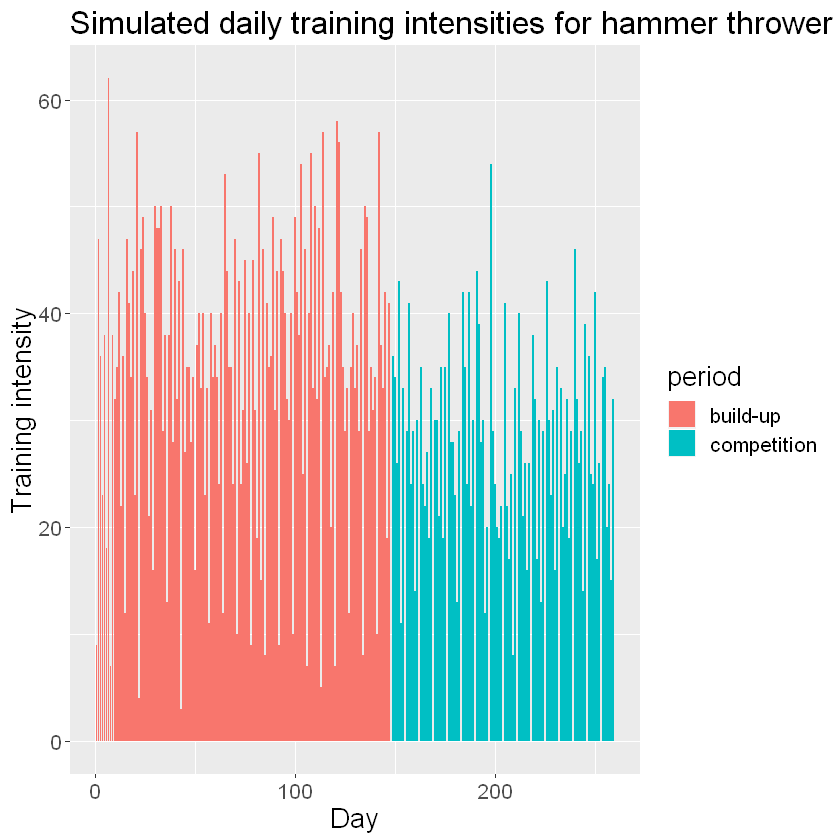

In [3]:
train_df <- data.frame(day = 1:259, day_of_week = 0:258 %% 7)
train_df$period <- ifelse(train_df$day <= 147, "build-up", "competition")
train_df$w <- with(train_df, w <-
  -24 * (day_of_week == 0) +
   12 * (day_of_week == 1) +
    8 * (day_of_week == 2) +
    0 * (day_of_week == 3) +
    6 * (day_of_week == 4) +
   -8 * (day_of_week == 5) +
    6 * (day_of_week == 6))

train_df$w <- rpois(nrow(train_df),
                    train_df$w + ifelse(train_df$period == "build-up", 34, 24))

mean(train_df$w[train_df$day <= 147])
mean(train_df$w[train_df$day > 147])

ggplot(train_df, aes(x = day, y = w)) +
  geom_bar(aes(fill = period), stat = "identity") +
  ggtitle("Simulated daily training intensities for hammer thrower") +
  xlab("Day") + ylab("Training intensity") +
  theme(text = element_text(size = 16))


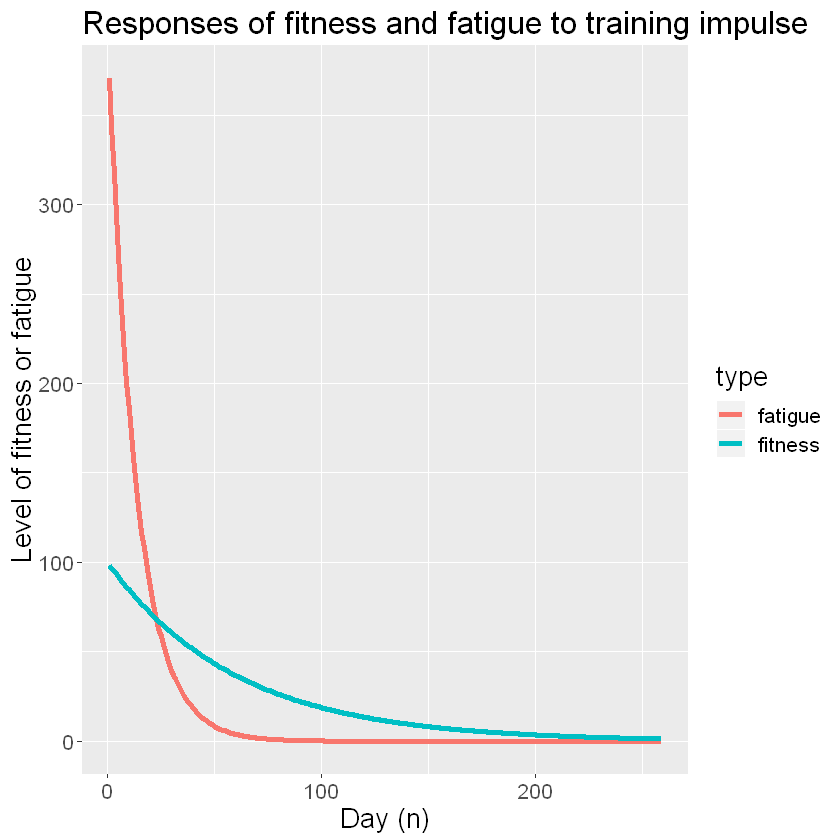

In [5]:
# Exponential decay and fitness-fatigue profiles
exp_decay <- function(t, tau) {
  exp(-t / tau)
}

grid_df <- rbind(data.frame(day = 1:259, level = 400 * exp_decay(1:259, 13),
                            type = "fatigue"),
                 data.frame(day = 1:259, level = 100 * exp_decay(1:259, 60),
                            type = "fitness"))

ggplot(grid_df, aes(x = day, y = level)) +
  geom_line(aes(color = type), size = 1.5) +
  ggtitle("Responses of fitness and fatigue to training impulse") +
  xlab("Day (n)") + ylab("Level of fitness or fatigue") +
  theme(text = element_text(size = 16))


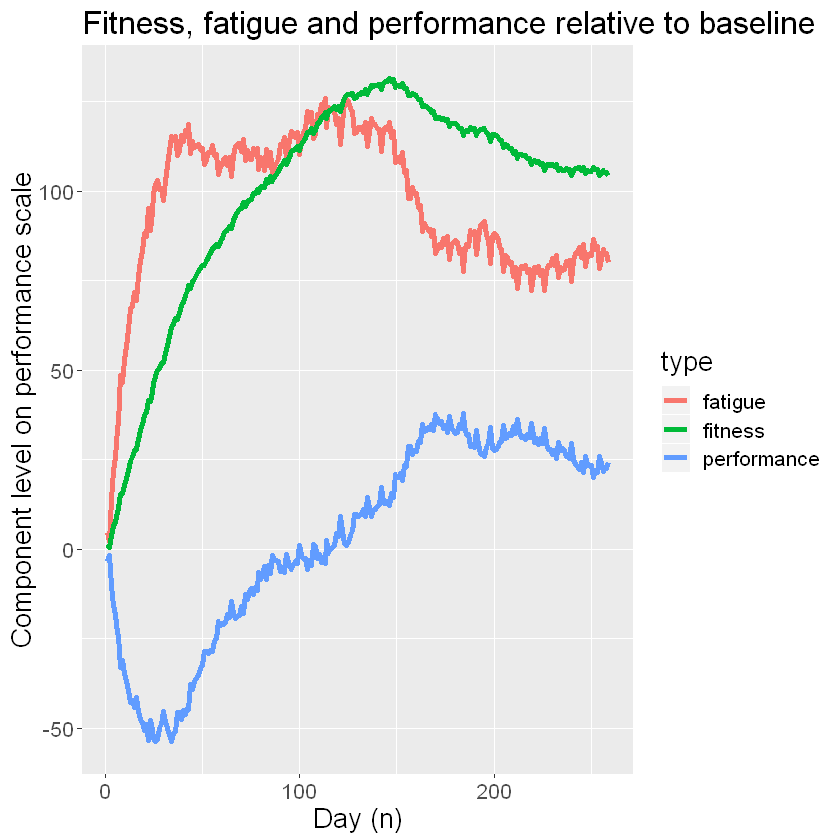

In [7]:
convolve_training <- function(training, n, tau) {
  sum(training[1:(n - 1)] * exp_decay((n - 1):1, tau))
}

fitness <- sapply(1:nrow(train_df),
                  function(n) convolve_training(train_df$w, n, 60))

fatigue <- sapply(1:nrow(train_df),
                  function(n) convolve_training(train_df$w, n, 13))

E_perf <- 496 + .07 * fitness - .27 * fatigue

set.seed(45345)
train_df$perf <- E_perf + 7.0 * rnorm(nrow(train_df))

components_df <- rbind(
  data.frame(level = .27 * fatigue, day = train_df$day, type = "fatigue"),
  data.frame(level = .07 *fitness, day = train_df$day, type = "fitness"),
  data.frame(level = E_perf - 496, day = train_df$day, type = "performance"))

ggplot(components_df, aes(x = day, y = level)) +
  geom_line(aes(color = type), size = 1.5) +
  ggtitle("Fitness, fatigue and performance relative to baseline") +
  xlab("Day (n)") + ylab("Component level on performance scale") +
  theme(text = element_text(size = 16))


In [ ]:
# Recover parameters using non-linear regression
rss <- function(theta) {
  int  <- theta[1] # performance baseline
  k1   <- theta[2] # fitness weight
  k2   <- theta[3] # fatigue weight
  tau1 <- theta[4] # fitness decay
  tau2 <- theta[5] # fatigue decay

  fitness <- sapply(1:nrow(train_df),
                    function(n) convolve_training(train_df$w, n, tau1))

  fatigue <- sapply(1:nrow(train_df),
                    function(n) convolve_training(train_df$w, n, tau2))

  perf_hat <- int + k1 * fitness - k2 * fatigue
  return(sum((train_df$perf - perf_hat) ^ 2))
}


optim_results <- optim(c(400, .05, .15, 20, 5), rss, method = "BFGS",
                       hessian = TRUE, control = list(maxit = 1000))
print(optim_results$par)
print(sqrt(diag(solve(optim_results$hessian))))
